In [1]:
!pip install ragas pandas numpy matplotlib seaborn

INFO: pip is looking at multiple versions of langchain-community to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of langchain-openai to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.6/317.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.5/155.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.0/352.0 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.0 M

In [2]:
import pandas as pd
from datasets import Dataset

def prepare_ragas_dataset(df: pd.DataFrame, answer_column: str) -> Dataset:
    data_dict = {
        'question': ['What are the key findings in this case?'] * len(df),
        'contexts': [[ctx] for ctx in df['impression'].tolist()],
        'answer': df[answer_column].tolist(),
        'ground_truth': df['impression'].tolist()
    }
    return Dataset.from_dict(data_dict)

baseline_df = pd.read_csv('/content/baseline_results_10examples (1).csv')
lora_df = pd.read_csv('/content/lora_training_results_10examples (2).csv')

baseline_dataset = prepare_ragas_dataset(baseline_df, 'base_answer')
lora_dataset = prepare_ragas_dataset(lora_df, 'lora_answer')

print("Datasets prepared for evaluation.")

Datasets prepared for evaluation.


In [ ]:
import os

os.environ["OPENAI_API_KEY"] = "sR..."

In [4]:
from ragas import evaluate
from ragas.metrics import (
    answer_correctness,
    answer_similarity,
    answer_relevancy
)

# evaluating the models using the RAGAS metrics.
def evaluate_model(dataset: Dataset, model_name: str):
    print(f"\nEvaluating {model_name}...")

    metrics = [
        answer_correctness,
        answer_similarity,
        answer_relevancy
    ]


    results = evaluate(
        dataset=dataset,
        metrics=metrics
    )

    return results


print("Running RAGAS evaluations.")
baseline_results = evaluate_model(baseline_dataset, "Base Model")
lora_results = evaluate_model(lora_dataset, "LoRA Model")

Running RAGAS evaluations.

Evaluating Base Model...


Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]


Evaluating LoRA Model...


Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]


--------------------------------------------------
BASELINE MODEL RESULTS
--------------------------------------------------
{'answer_correctness': 0.5392, 'answer_similarity': 0.9228, 'answer_relevancy': 0.8049}

--------------------------------------------------
LoRA MODEL RESULTS
--------------------------------------------------
{'answer_correctness': 0.5780, 'answer_similarity': 0.9240, 'answer_relevancy': 0.7143}

--------------------------------------------------
Metrics comparison (mean scores)
--------------------------------------------------
            Metric  Baseline     LoRA
Answer Correctness  0.539246 0.578004
 Answer Similarity  0.922773 0.924008
  Answer Relevancy  0.804855 0.714279

--------------------------------------------------
Detailed comparison with improvement.
--------------------------------------------------
            Metric  Baseline     LoRA  Improvement (%)
Answer Correctness  0.539246 0.578004             7.19
 Answer Similarity  0.922773 0.924008

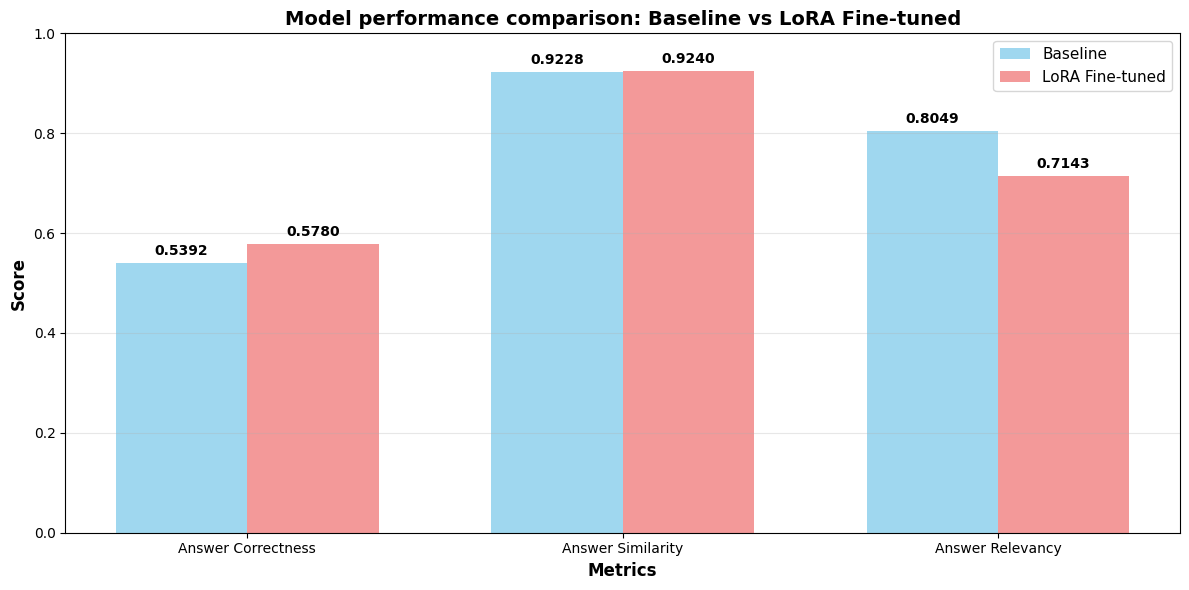


--------------------------------------------------
Summary.
--------------------------------------------------
Average Baseline score: 0.7556
Average LoRA score: 0.7388
Overall improvement: -2.23%

--------------------------------------------------
Per-metric improvement.
--------------------------------------------------
Answer Correctness: increased 7.19%
Answer Similarity: increased 0.13%
Answer Relevancy: decreased 11.25%


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


print("\n" + "-"*50)
print("BASELINE MODEL RESULTS")
print("-"*50)
print(baseline_results)

print("\n" + "-"*50)
print("LoRA MODEL RESULTS")
print("-"*50)
print(lora_results)

# mean score.
def get_mean_score(results, metric_name):
    value = results[metric_name]
    if isinstance(value, list):
        return np.mean(value)
    return value

# comparing metrics by calculating the means.
metrics_comparison = pd.DataFrame({
    'Metric': ['Answer Correctness', 'Answer Similarity', 'Answer Relevancy'],
    'Baseline': [
        get_mean_score(baseline_results, 'answer_correctness'),
        get_mean_score(baseline_results, 'answer_similarity'),
        get_mean_score(baseline_results, 'answer_relevancy')
    ],
    'LoRA': [
        get_mean_score(lora_results, 'answer_correctness'),
        get_mean_score(lora_results, 'answer_similarity'),
        get_mean_score(lora_results, 'answer_relevancy')
    ]
})

print("\n" + "-"*50)
print("Metrics comparison (mean scores)")
print("-"*50)
print(metrics_comparison.to_string(index=False))

# caluclating improvement.
metrics_comparison['Improvement (%)'] = ((metrics_comparison['LoRA'] - metrics_comparison['Baseline']) / metrics_comparison['Baseline'] * 100).round(2)

print("\n" + "-"*50)
print("Detailed comparison with improvement.")
print("-"*50)
print(metrics_comparison.to_string(index=False))

fig, ax = plt.subplots(figsize=(12, 6))
x = range(len(metrics_comparison))
width = 0.35

baseline_bars = ax.bar([i - width/2 for i in x], metrics_comparison['Baseline'],
                        width, label='Baseline', alpha=0.8, color='skyblue')
lora_bars = ax.bar([i + width/2 for i in x], metrics_comparison['LoRA'],
                    width, label='LoRA Fine-tuned', alpha=0.8, color='lightcoral')

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model performance comparison: Baseline vs LoRA Fine-tuned', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_comparison['Metric'], rotation=0, ha='center')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

for bars in [baseline_bars, lora_bars]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# statistics.
print("\n" + "-"*50)
print("Summary.")
print("-"*50)
avg_baseline = metrics_comparison['Baseline'].mean()
avg_lora = metrics_comparison['LoRA'].mean()
overall_improvement = ((avg_lora - avg_baseline) / avg_baseline * 100)

print(f"Average Baseline score: {avg_baseline:.4f}")
print(f"Average LoRA score: {avg_lora:.4f}")
print(f"Overall improvement: {overall_improvement:.2f}%")

print("\n" + "-"*50)
print("Per-metric improvement.")
print("-"*50)
for idx, row in metrics_comparison.iterrows():
    improvement = row['Improvement (%)']
    direction = "increased" if improvement > 0 else "decreased"
    print(f"{row['Metric']}: {direction} {abs(improvement):.2f}%")